## LangChain v1 Agents: Complete Guide

## Prerequisites

Make sure you have the required packages installed and Ollama running:

```bash
pip install -U langchain langchain-community langchain-core langgraph
pip install -U ddgs python-dotenv
```

Local LLM Serving with Ollama:
```bash
ollama pull qwen3
ollama pull gemma3
```

In [1]:
# pip install -U langchain langchain-community langchain-core langgraph
# pip install -U ddgs python-dotenv

---
## 1. Agent with Explicit Model Instance

Full control over model configuration by creating an explicit ChatOllama instance.

## Model Parameters Explained
- **temperature**: Controls randomness (0.0 = deterministic, 1.0 = very creative)
- **num_predict**: Maximum tokens to generate (similar to max_tokens in OpenAI)
- **top_k**: Number of highest probability tokens to consider
- **top_p**: Cumulative probability threshold for token selection
- **repeat_penalty**: Penalty for repeating tokens
- **num_ctx**: Context window size

In [2]:
from langchain_ollama import ChatOllama
from langchain.agents import create_agent
import tools

In [3]:
system_prompt = """You are a helpful AI assistant. 
Use the available tools when needed to answer questions accurately.
If you need to search for information, use the web_search tool.
Always provide clear and concise answers.
"""

In [4]:
print(tools.web_search.invoke({"query": "What is Langchain?", "num_results": 1}))

Search Results for 'What is Langchain?':


1. **使用 LangChain 和 LangGraph 构建一个简单的多智能体系统 - 石头木 -...**
   13 hours ago · 本文介绍了一个简单的多智能体系统的实现，使用 LangChain 结合 LangGraph 来构建这样的系统，LangGraph 作为 LangChain 生态的重要组成部分，专为构建有状态、多智能体的工作流而设计，非常适合实现复杂的智能体协作场景。
   https://www.cnblogs.com/little-horse/p/19154508


### Your First Agent

In [5]:
model = ChatOllama(model="qwen3", base_url="http://localhost:11434")

In [6]:
agent = create_agent(model=model, tools=[tools.web_search], system_prompt=system_prompt)

In [7]:
result = agent.invoke({"messages": "What is the top 10 global news right now?"})

In [8]:
result

{'messages': [HumanMessage(content='What is the top 10 global news right now?', additional_kwargs={}, response_metadata={}, id='a66b084a-c5a9-4598-828d-2c65af0f76ec'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-10-21T13:32:00.3965031Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3093137100, 'load_duration': 1493448200, 'prompt_eval_count': 245, 'prompt_eval_duration': 36706500, 'eval_count': 284, 'eval_duration': 1460630300, 'model_name': 'qwen3', 'model_provider': 'ollama'}, id='lc_run--55742059-42cc-4cf9-b3cf-1c05180168b9-0', tool_calls=[{'name': 'web_search', 'args': {'num_results': 10, 'query': 'top 10 global news'}, 'id': '6939b9bb-b63d-492f-bf28-f6e82bb75a03', 'type': 'tool_call'}], usage_metadata={'input_tokens': 245, 'output_tokens': 284, 'total_tokens': 529}),
  ToolMessage(content='Search Results for \'top 10 global news\':\n\n\n1. **Asia Pacific cities hold steady at the top amid global ...**\n   13 hour

In [9]:
# print(result['messages'][-1].content)
# result['messages'][-1].pretty_print()

In [10]:
result1 = agent.invoke(result)

In [11]:
result1

{'messages': [HumanMessage(content='What is the top 10 global news right now?', additional_kwargs={}, response_metadata={}, id='a66b084a-c5a9-4598-828d-2c65af0f76ec'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-10-21T13:32:00.3965031Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3093137100, 'load_duration': 1493448200, 'prompt_eval_count': 245, 'prompt_eval_duration': 36706500, 'eval_count': 284, 'eval_duration': 1460630300, 'model_name': 'qwen3', 'model_provider': 'ollama'}, id='lc_run--55742059-42cc-4cf9-b3cf-1c05180168b9-0', tool_calls=[{'name': 'web_search', 'args': {'num_results': 10, 'query': 'top 10 global news'}, 'id': '6939b9bb-b63d-492f-bf28-f6e82bb75a03', 'type': 'tool_call'}], usage_metadata={'input_tokens': 245, 'output_tokens': 284, 'total_tokens': 529}),
  ToolMessage(content='Search Results for \'top 10 global news\':\n\n\n1. **Asia Pacific cities hold steady at the top amid global ...**\n   13 hour

### Experimenting with Different Settings

Let's compare different model configurations to see how they affect the output:

In [12]:
question = "What is the capital of France? Provide a brief explanation."

model1 = ChatOllama(model="qwen3", base_url="http://localhost:11434",
                    temperature=0,
                    top_p=1,
                    repeart_penalty=1.2,
                    num_predict=1000,
                    num_ctx=4096,
                    reasoning=True)

agent1 = create_agent(model=model1, tools=[tools.web_search], system_prompt=system_prompt)
result1 = agent1.invoke({"messages": question})

In [13]:
result1

{'messages': [HumanMessage(content='What is the capital of France? Provide a brief explanation.', additional_kwargs={}, response_metadata={}, id='0ad6bb32-a2c6-4791-a2c8-fb1c68d42519'),
  AIMessage(content='The capital of France is **Paris**. Paris is not only the political and cultural center of France but also a major global city known for its landmarks like the Eiffel Tower, Louvre Museum, and historic architecture. It serves as the seat of the French government and is a hub for art, fashion, and commerce. \n\n', additional_kwargs={'reasoning_content': 'Okay, the user is asking for the capital of France and a brief explanation. Let me start by recalling what I know. France is a country in Europe, and I believe the capital is Paris. But wait, I should make sure that\'s correct. Maybe I should check using the web_search tool to confirm. Let me think, the function requires a query and optionally the number of results. The query here would be "capital of France". The user wants a brief 

## 2. Dynamic Model Selection (Qwen3 → Gemma3)

Cost-optimization strategy where the agent automatically switches between models based on conversation complexity.

## Selection Logic
- **< 10 messages**: Use Qwen3 (fast, efficient)
- **≥ 10 messages**: Use Gemma3 (better reasoning, longer context)

## Real-World Applications
- Customer service bots (simple queries → Qwen3, complex issues → Gemma3)
- Research assistants (quick facts → Qwen3, analysis → Gemma3)

In [25]:
# Import required modules
from langchain_ollama import ChatOllama
from langchain.agents import create_agent, AgentState
from langgraph.runtime import Runtime
import tools

# Import the middleware decorator
from langchain.agents.middleware import wrap_model_call, ModelRequest, ModelResponse


In [42]:
basic_model = ChatOllama(model="qwen3", base_url="http://localhost:11434", num_predict=1000)

advanced_model = ChatOllama(model="llama3.2", base_url="http://localhost:11434", num_predict=1000)

@wrap_model_call
def dynamic_model_selection(request: ModelRequest, handler) -> ModelResponse:
    message_count = len(request.state["messages"])

    if message_count<3:
        print(f"Using Qwen3 for {message_count} messages")
        request.model = basic_model

    else:
        print(f"Using llama3.2 for {message_count} messages")
        request.model = advanced_model

    return handler(request)

In [43]:
agent = create_agent(model=basic_model,
                     tools = [tools.web_search],
                     system_prompt=system_prompt,
                     middleware=[dynamic_model_selection])

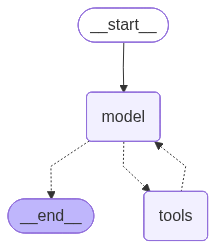

In [44]:
agent

In [45]:
def get_agent_output(messages:list):
    messages = {'messages': messages} # dict

    result = agent.invoke(messages)

    return result

In [46]:
messages = ["How are you?", "What's the weather in Mumbai today?"]
result = get_agent_output(messages)

Using Qwen3 for 2 messages
Using llama3.2 for 4 messages


In [47]:
result


{'messages': [HumanMessage(content='How are you?', additional_kwargs={}, response_metadata={}, id='a1846f3d-3768-49ab-b144-dce233bc8772'),
  HumanMessage(content="What's the weather in Mumbai today?", additional_kwargs={}, response_metadata={}, id='11a04da6-1c11-4d34-8863-b13249bcc149'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-10-21T13:36:12.359814Z', 'done': True, 'done_reason': 'stop', 'total_duration': 8791898800, 'load_duration': 3312368400, 'prompt_eval_count': 245, 'prompt_eval_duration': 55305100, 'eval_count': 424, 'eval_duration': 5325115900, 'model_name': 'qwen3', 'model_provider': 'ollama'}, id='lc_run--432237fd-32ed-4776-8d9f-4c5cd11ef16e-0', tool_calls=[{'name': 'web_search', 'args': {'num_results': 1, 'query': 'weather in Mumbai today'}, 'id': '576e4f77-beaa-43fe-86a0-9706577cc1ba', 'type': 'tool_call'}], usage_metadata={'input_tokens': 245, 'output_tokens': 424, 'total_tokens': 669}),
  ToolMessage(content="S

### Streaming Agent Responses
#### Stream Modes
- "values": Get complete state at each step
- "updates": Get only the changes/updates
- "messages": Get only message updates

In [54]:
for chunk in agent.stream({"messages": messages}, stream_mode="values"):
    print(chunk['messages'][-1].content, end='', flush=True)

    print("\n\n------")

What's the weather in Mumbai today?

------
Using Qwen3 for 2 messages
I'm just a bunch of code, so I don't have feelings, but I'm here to help! 😊

For the weather in Mumbai today, let me check that for you...



------
Search Results for 'weather in Mumbai today':


1. **14-day weather forecast for Mumbai . - BBC Weather**
   Mumbai - Weather warnings issued. 14-day forecast.See more weather for. Thursday 18th. Last updated today at 12:29.
   https://www.bbc.com/weather/1275339

------
Using llama3.2 for 4 messages
I'm just a language model, I don't have feelings or emotions like humans do, but thank you for asking! As for the weather in Mumbai today, according to the latest forecast, there are no specific weather warnings issued. However, you can check the current weather conditions and 14-day forecast on BBC Weather's website for the most up-to-date information: https://www.bbc.com/weather/1275339

------


In [53]:
for chunk in agent.stream({"messages": messages}, stream_mode="updates"):
    # print(chunk, end='', flush=True)
    if 'model' in chunk:
        chunk['model']['messages'][-1].pretty_print()
    if 'tools' in chunk:
        chunk['tools']['messages'][-1].pretty_print()
    else:
        print(chunk)
    print("\n\n------")

Using Qwen3 for 2 messages
================================== Ai Message ==================================

I'm just a virtual assistant, but I'm here and ready to help! 😊

For the weather in Mumbai today, let me check that for you:
Tool Calls:
  web_search (67d171bb-8c26-4a1c-899e-573139dfe937)
 Call ID: 67d171bb-8c26-4a1c-899e-573139dfe937
  Args:
    num_results: 10
    query: weather in Mumbai today
{'model': {'messages': [AIMessage(content="I'm just a virtual assistant, but I'm here and ready to help! 😊\n\nFor the weather in Mumbai today, let me check that for you:\n\n", additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-10-21T13:48:11.2237099Z', 'done': True, 'done_reason': 'stop', 'total_duration': 4622333400, 'load_duration': 63401800, 'prompt_eval_count': 245, 'prompt_eval_duration': 37308800, 'eval_count': 306, 'eval_duration': 4476609200, 'model_name': 'qwen3', 'model_provider': 'ollama'}, id='lc_run--9b563b2b-cb7c-46de-aa2f-bcc6787046b3-0', tool